In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import make_scorer, mean_squared_error
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, RegressorMixin


In [99]:
# Load the regression dataset
regression_data = pd.read_csv("prices.csv")

In [100]:
regression_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [101]:
regression_data.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,70.836986,70.857109,70.118414,71.543476,5.415113e+06
std,83.695876,83.689686,82.877294,84.465504,1.249468e+07
min,0.850000,0.860000,0.830000,0.880000,0.000000e+00
25%,33.840000,33.849998,33.480000,34.189999,1.221500e+06
50%,52.770000,52.799999,52.230000,53.310001,2.476250e+06
75%,79.879997,79.889999,79.110001,80.610001,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [102]:
regression_data.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [103]:
regression_data.isnull().sum()

date      0
symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64

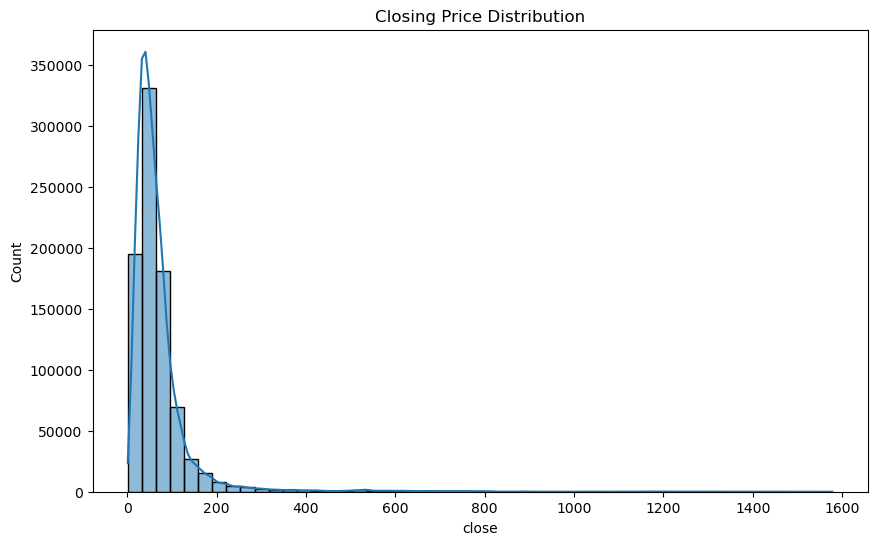

In [104]:
plt.figure(figsize=(10,6))
sns.histplot(regression_data['close'], bins=50, kde=True)
plt.title("Closing Price Distribution")
plt.show()

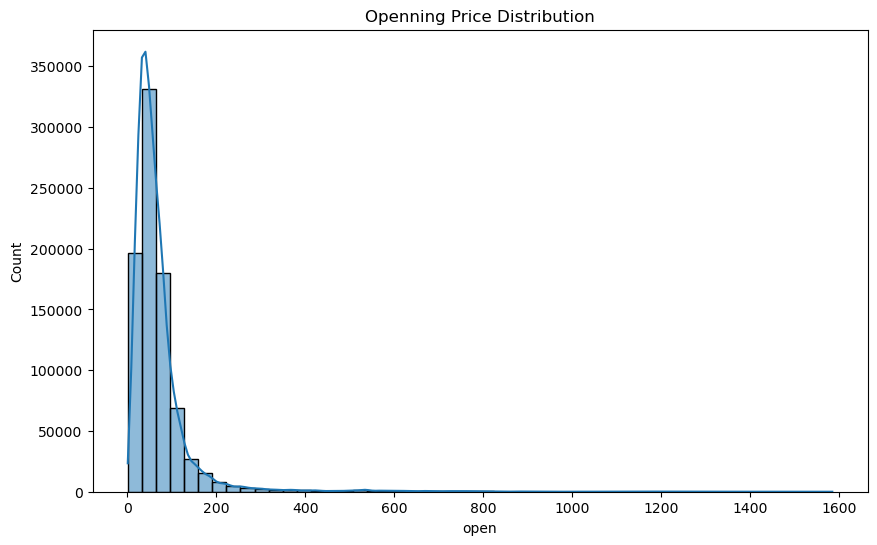

In [105]:
plt.figure(figsize=(10,6))
sns.histplot(regression_data['open'], bins=50, kde=True)
plt.title("Openning Price Distribution")
plt.show()

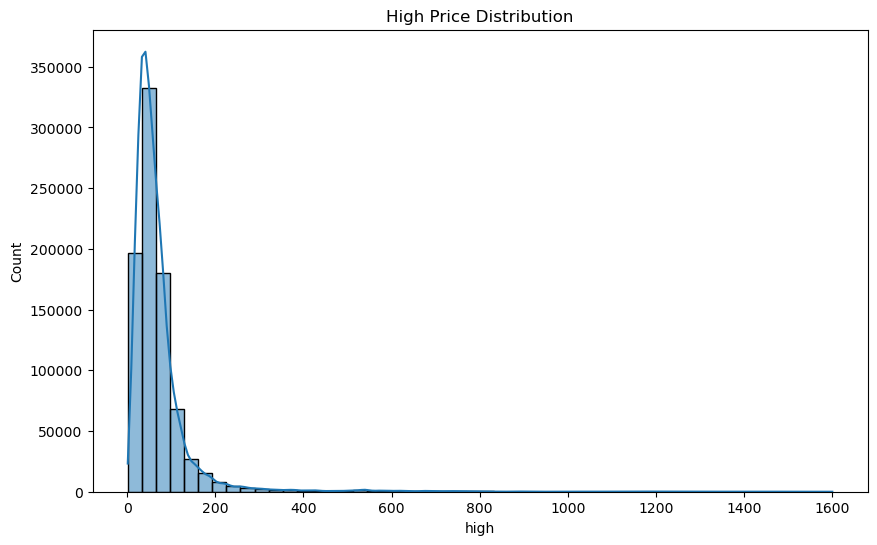

In [106]:
plt.figure(figsize=(10,6))
sns.histplot(regression_data['high'], bins=50, kde=True)
plt.title("High Price Distribution")
plt.show()

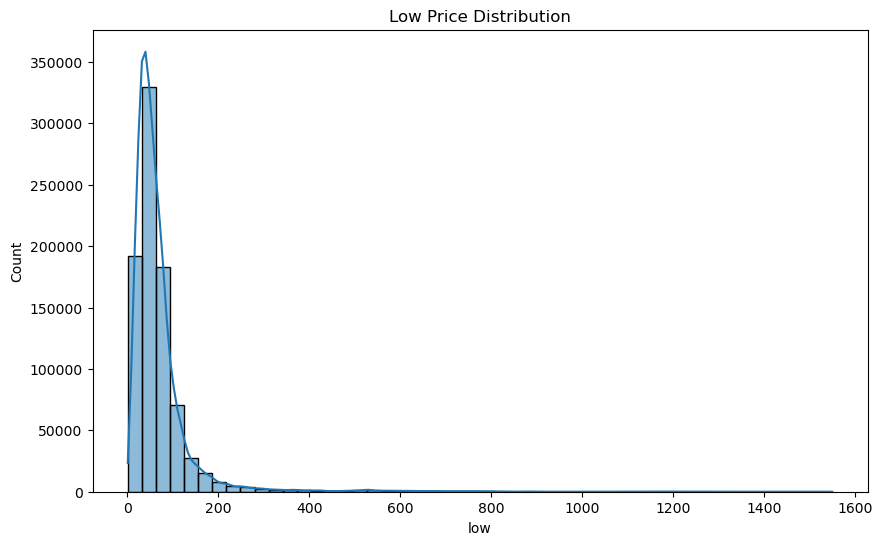

In [107]:
plt.figure(figsize=(10,6))
sns.histplot(regression_data['low'], bins=50, kde=True)
plt.title("Low Price Distribution")
plt.show()

In [108]:
# Feature selection and preprocessing
features = regression_data.drop(columns=["close","date","symbol"]).values  # Replace with actual target column
labels = regression_data["close"].values

In [109]:
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [110]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [111]:
#  Ensure no NaN values in data
X_train = np.nan_to_num(X_train, nan=0.0)
y_train = np.nan_to_num(y_train, nan=0.0)
X_test = np.nan_to_num(X_test, nan=0.0)
y_test = np.nan_to_num(y_test, nan=0.0)

In [112]:
#  Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [113]:
#  Define PyTorch Regression Model with  stable initialization
class RegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_size=64):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
        
        # Initialize weights with a more stable method
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [114]:
#  Wrapper class to use PyTorch model with GridSearchCV
class TorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, learning_rate=0.01, optimizer_type="Adam", epochs=50, hidden_size=64):
        self.learning_rate = learning_rate
        self.optimizer_type = optimizer_type
        self.epochs = epochs
        self.hidden_size = hidden_size
        self.model = None

    def fit(self, X, y):
        # Convert input to numpy if it's not already
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        if not isinstance(y, np.ndarray):
            y = np.array(y)
            
        # Clean any potential NaN values
        X = np.nan_to_num(X, nan=0.0)
        y = np.nan_to_num(y, nan=0.0)
        
        # Create fresh tensors
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

        # Initialize model
        self.model = RegressionModel(X.shape[1], self.hidden_size)
        criterion = nn.MSELoss()

        # Use the specified optimizer
        if self.optimizer_type in dir(optim):
            optimizer_class = getattr(optim, self.optimizer_type)
            optimizer = optimizer_class(self.model.parameters(), lr=self.learning_rate)
        else:
            # Default to Adam if optimizer not found
            optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

        # Training loop with gradient clipping to prevent exploding gradients
        for epoch in range(self.epochs):
            self.model.train()
            optimizer.zero_grad()
            outputs = self.model(X_tensor)
            loss = criterion(outputs, y_tensor)
            loss.backward()
            
            # Add gradient clipping to prevent NaN values
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            optimizer.step()
        
        return self

    def predict(self, X):
        # Handle potential NaN values in input
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        X = np.nan_to_num(X, nan=0.0)
        
        X_tensor = torch.tensor(X, dtype=torch.float32)
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(X_tensor).numpy()
            
        # Ensure predictions have no NaN values
        predictions = np.nan_to_num(predictions, nan=0.0)
        return predictions

    def score(self, X, y):
        try:
            y_pred = self.predict(X)
            # Handle any NaN values in the target
            if not isinstance(y, np.ndarray):
                y = np.array(y)
            y = np.nan_to_num(y, nan=0.0)
            
            # Make sure shapes match
            if y.ndim == 1 and y_pred.ndim == 2:
                y_pred = y_pred.ravel()
            
            # Ensure no NaN values in predictions
            if np.isnan(y_pred).any():
                return -np.inf  # Return worst possible score if NaNs persist
                
            return -mean_squared_error(y, y_pred)
        except Exception as e:
            print(f"Scoring error: {e}")
            return -np.inf  # Return worst possible score if scoring fails

# Define Hyperparameter Grid (use smaller grid for initial testing)
param_grid = {
    'learning_rate': [0.001, 0.01],
    'optimizer_type': ["Adam"],
    'epochs': [50],
    'hidden_size': [64]
}

#  Run GridSearchCV with error handling
try:
    grid_search = GridSearchCV(TorchRegressor(), param_grid, scoring='neg_mean_squared_error', 
                               cv=3, verbose=1, error_score=np.nan)
    grid_search.fit(X_train, y_train)

    #  Get Best Parameters
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best MSE Score: {-grid_search.best_score_}")

    #  Evaluate on Test Set
    best_model = grid_search.best_estimator_
    y_pred_test = best_model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    print(f"Test MSE: {test_mse:.4f}")
except Exception as e:
    print(f"An error occurred during grid search: {e}")
    
    # Fallback to a simple model with default parameters
    print("Falling back to a single model with default parameters...")
    simple_model = TorchRegressor(learning_rate=0.01, optimizer_type="Adam", epochs=50, hidden_size=64)
    simple_model.fit(X_train, y_train)
    y_pred_test = simple_model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    print(f"Test MSE with simple model: {test_mse:.4f}")

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Parameters: {'epochs': 50, 'hidden_size': 64, 'learning_rate': 0.01, 'optimizer_type': 'Adam'}
Best MSE Score: 5398.977285945285
Test MSE: 6431.6395


In [115]:
# Create data loaders for batching
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [117]:
# Define the model using best hidden_size
class RegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
        
        # Initialize weights with Xavier initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [118]:
from sklearn.metrics import  r2_score
from torch.utils.data import TensorDataset, DataLoader

# i asigned these values from the actual best parameters from the grid search
best_params = {
    'learning_rate': 0.01,  
    'optimizer_type': 'Adam',  
    'epochs': 50,  
    'hidden_size': 64 
}

print(f"Training with best parameters: {best_params}")
# Function to calculate accuracy for regression
def calculate_accuracy(y_true, y_pred, tolerance=0.1):
    """
    Define accuracy for regression as predictions within tolerance percentage of true value
    """
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    # Calculate absolute percentage error
    abs_percentage_error = np.abs(y_true - y_pred) / (np.abs(y_true) + 1e-8)
    
    # Count predictions within tolerance
    within_tolerance = np.mean(abs_percentage_error <= tolerance)
    return within_tolerance

# Train final model with best hyperparameters
model = RegressionModel(X_train.shape[1], best_params['hidden_size'])
criterion = nn.MSELoss()

# Set optimizer based on best_params
if best_params['optimizer_type'] == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])
else:
    optimizer = optim.SGD(model.parameters(), lr=best_params['learning_rate'])

# Training loop
epochs = best_params['epochs']
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        
        # Add gradient clipping to prevent NaN values
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    avg_train_loss = train_loss / len(train_dataset)
    train_losses.append(avg_train_loss)
    
    # Calculate training accuracy
    model.eval()
    train_preds = []
    train_targets = []
    with torch.no_grad():
        for inputs, targets in train_loader:
            outputs = model(inputs)
            train_preds.append(outputs.numpy())
            train_targets.append(targets.numpy())
    
    train_preds = np.vstack(train_preds)
    train_targets = np.vstack(train_targets)
    train_accuracy = calculate_accuracy(train_targets, train_preds)
    train_accuracies.append(train_accuracy)
    
    # Evaluation phase
    model.eval()
    test_loss = 0.0
    test_preds = []
    test_targets = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            test_preds.append(outputs.numpy())
            test_targets.append(targets.numpy())
    
    avg_test_loss = test_loss / len(test_dataset)
    test_losses.append(avg_test_loss)
    
    test_preds = np.vstack(test_preds)
    test_targets = np.vstack(test_targets)
    test_accuracy = calculate_accuracy(test_targets, test_preds)
    test_accuracies.append(test_accuracy)
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")




Training with best parameters: {'learning_rate': 0.01, 'optimizer_type': 'Adam', 'epochs': 50, 'hidden_size': 64}
Epoch 1/50, Train Loss: 32.1023, Test Loss: 0.5760, Train Accuracy: 0.9961, Test Accuracy: 0.9958
Epoch 5/50, Train Loss: 0.8133, Test Loss: 0.6156, Train Accuracy: 0.9894, Test Accuracy: 0.9894
Epoch 10/50, Train Loss: 0.7069, Test Loss: 0.9781, Train Accuracy: 0.9993, Test Accuracy: 0.9992
Epoch 15/50, Train Loss: 0.6209, Test Loss: 0.4591, Train Accuracy: 0.9995, Test Accuracy: 0.9995
Epoch 20/50, Train Loss: 0.5997, Test Loss: 0.4232, Train Accuracy: 0.9994, Test Accuracy: 0.9993
Epoch 25/50, Train Loss: 0.5789, Test Loss: 0.4168, Train Accuracy: 0.9994, Test Accuracy: 0.9993
Epoch 30/50, Train Loss: 0.5579, Test Loss: 0.5004, Train Accuracy: 0.9992, Test Accuracy: 0.9991
Epoch 35/50, Train Loss: 0.5496, Test Loss: 0.5645, Train Accuracy: 0.9994, Test Accuracy: 0.9995
Epoch 40/50, Train Loss: 0.5422, Test Loss: 0.5162, Train Accuracy: 0.9973, Test Accuracy: 0.9972
Epoch

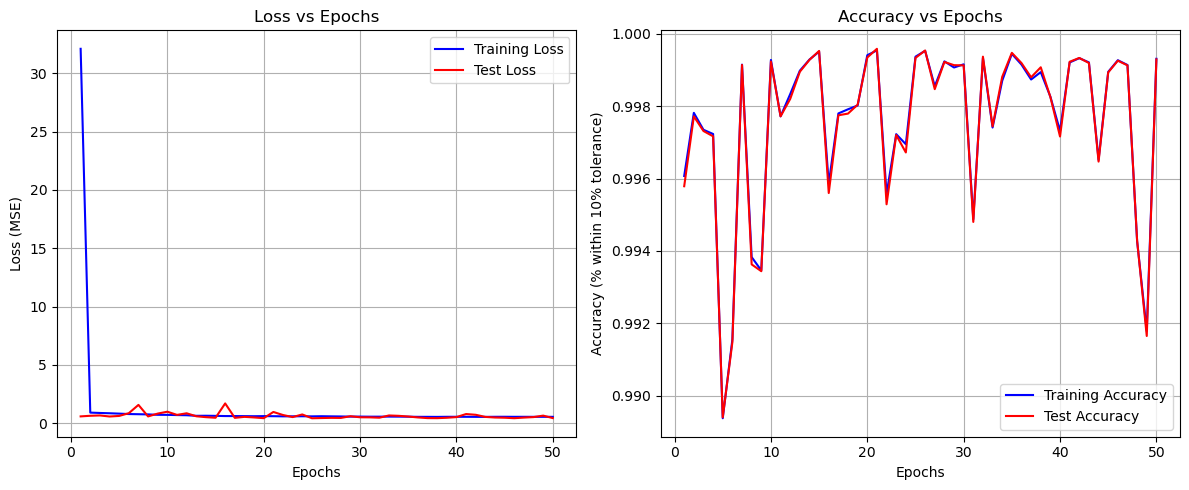

In [120]:
# Visualize Loss/Epochs and Accuracy/Epochs
plt.figure(figsize=(12, 5))

# Plot Loss vs Epochs
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, 'r-', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid(True)

# Plot Accuracy vs Epochs
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, 'b-', label='Training Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, 'r-', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (% within 10% tolerance)')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

In [122]:

# Final evaluation on test set
model.eval()
final_predictions = []
final_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        final_predictions.append(outputs.numpy())
        final_targets.append(targets.numpy())

final_predictions = np.vstack(final_predictions)
final_targets = np.vstack(final_targets)

final_mse = mean_squared_error(final_targets, final_predictions)
final_r2 = r2_score(final_targets.flatten(), final_predictions.flatten())
final_accuracy = calculate_accuracy(final_targets, final_predictions)

print("\n--- Final Model Performance ---")
print(f"Mean Squared Error: {final_mse:.4f}")
print(f"R-squared: {final_r2:.4f}")
print(f"Accuracy (within 10% tolerance): {final_accuracy:.4f}")



--- Final Model Performance ---
Mean Squared Error: 0.4300
R-squared: 0.9999
Accuracy (within 10% tolerance): 0.9993


### **The model shows some signs of overfitting (r-2: 0.999) and training and test losses are close.**